# **Initialization**

In [ ]:
!pip install pycaret

     |████████████████████████████████| 288 kB 5.1 MB/s 
     |████████████████████████████████| 2.0 MB 18.5 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 6.8 MB 22.9 MB/s 
     |████████████████████████████████| 261 kB 45.4 MB/s 
     |████████████████████████████████| 167 kB 55.1 MB/s 
     |████████████████████████████████| 1.3 MB 44.8 MB/s 
     |████████████████████████████████| 15.5 MB 46.0 MB/s 
     |████████████████████████████████| 1.7 MB 35.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 113 kB 43.7 MB/s 
     |████████████████████████████████| 675 kB 51.4 MB/s 
     |████████████████████████████████| 3.1 MB 54.6 MB/s 
     |████████████████████████████████| 62 kB 804 kB/s 
     |███████████████████

In [ ]:
import pandas as pd
from pycaret.clustering import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Data**

In [ ]:
#Import data
df = pd.read_csv('/content/drive/My Drive/Classroom/SupermarketData.csv')
df['SHOP_DATE'] = df['SHOP_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df.head(5)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200732,2007-10-05,6,17,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000583261,UM,YF,994107800547472,L,MM,Top Up,Grocery,STORE00001,LS,E02
1,200733,2007-10-10,4,20,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000537317,MM,OF,994107900512001,L,MM,Full Shop,Fresh,STORE00001,LS,E02
2,200741,2007-12-09,1,11,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000472158,MM,YF,994108700468327,L,MM,Full Shop,Grocery,STORE00001,LS,E02
3,200731,2007-09-29,7,17,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000099658,LA,OF,994107700237811,L,LA,Full Shop,Mixed,STORE00001,LS,E02
4,200737,2007-11-10,7,14,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,NaN,NaN,NaN,994108300002212,L,MM,Full Shop,Fresh,STORE00001,LS,E02


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956574 entries, 0 to 956573
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SHOP_WEEK                 956574 non-null  int64         
 1   SHOP_DATE                 956574 non-null  datetime64[ns]
 2   SHOP_WEEKDAY              956574 non-null  int64         
 3   SHOP_HOUR                 956574 non-null  int64         
 4   QUANTITY                  956574 non-null  int64         
 5   SPEND                     956574 non-null  float64       
 6   PROD_CODE                 956574 non-null  object        
 7   PROD_CODE_10              956574 non-null  object        
 8   PROD_CODE_20              956574 non-null  object        
 9   PROD_CODE_30              956574 non-null  object        
 10  PROD_CODE_40              956574 non-null  object        
 11  CUST_CODE                 802892 non-null  object        
 12  CU

# **Prepare Customer Single View**

### Feature Engineering

In [ ]:
#Total customers
df['CUST_CODE'].nunique()

6100

In [ ]:
#Last txn date
max_date = df['SHOP_DATE'].max()
max_date

Timestamp('2008-07-06 00:00:00')

In [ ]:
#Prepare customer single view
df_csv = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE']).agg(TotalSpend=('SPEND', 'sum'),
                                                                                  TotalVisits=('BASKET_ID', 'nunique'),
                                                                                  TotalSKUs=('PROD_CODE', 'nunique'),
                                                                                  FirstDate=('SHOP_DATE', 'min'),
                                                                                  LastDate=('SHOP_DATE', 'max')
                                                                                  ).reset_index()

In [ ]:
#Calculate total days of the relationship
df_csv['total_days'] = (df_csv['LastDate'] - df_csv['FirstDate']).dt.days + 1

In [ ]:
#Calculate recency days
df_csv['recency'] = (max_date - df_csv['LastDate']).dt.days

In [ ]:
df_csv.head(5)

,CUST_CODE,TotalSpend,TotalVisits,TotalSKUs,FirstDate,LastDate,total_days,recency
0,CUST0000000181,2.44,1,1,2007-01-06,2007-01-06,1,547
1,CUST0000000369,959.33,220,189,2006-04-16,2008-07-05,812,1
2,CUST0000000689,328.57,16,116,2007-07-22,2008-06-23,338,13
3,CUST0000000998,5.95,3,4,2006-05-04,2006-07-07,65,730
4,CUST0000001163,39.74,4,24,2006-10-22,2008-06-22,610,14


In [ ]:
#Purchase consistency
lifetime = df.sort_values(by=['CUST_CODE','SHOP_DATE'], ascending=True).drop_duplicates(subset=['CUST_CODE'])
lifetime = lifetime[~(lifetime['CUST_CODE'].isnull())]
lifetime['MAX_DATE'] = max_date
lifetime['LIFETIME_DAYS'] = (lifetime['MAX_DATE'] - lifetime['SHOP_DATE']).dt.days
lifetime['LIFETIME_WEEKS'] = lifetime['LIFETIME_DAYS']/7
lifetime = lifetime[['CUST_CODE','LIFETIME_WEEKS']]

active_weeks = df.groupby(by=['CUST_CODE']).agg(TTL_ACTIVE_WEEKS = ('SHOP_WEEK','nunique')).reset_index()

combined_df = active_weeks.merge(lifetime, on=['CUST_CODE'])
combined_df['PURCHASE_CONSISTENCY'] = combined_df['TTL_ACTIVE_WEEKS']/combined_df['LIFETIME_WEEKS']
combined_df.head(5)

,CUST_CODE,TTL_ACTIVE_WEEKS,LIFETIME_WEEKS,PURCHASE_CONSISTENCY
0,CUST0000000181,1,78.142857,0.012797
1,CUST0000000369,103,116.000000,0.887931
2,CUST0000000689,13,50.000000,0.260000
3,CUST0000000998,3,113.428571,0.026448
4,CUST0000001163,4,89.000000,0.044944


In [ ]:
#Weekly basket
weekly_basket = df.groupby(by=['CUST_CODE','SHOP_WEEK']).agg(ttl_wkly_basket=('BASKET_ID','nunique')).reset_index().groupby(by='CUST_CODE').agg(AVG_WKLY_BASKET = ('ttl_wkly_basket','mean'), SD_WKLY_BASKET = ('ttl_wkly_basket','std')).reset_index()
weekly_basket.head(5)

,CUST_CODE,AVG_WKLY_BASKET,SD_WKLY_BASKET
0,CUST0000000181,1.000000,NaN
1,CUST0000000369,2.135922,1.048328
2,CUST0000000689,1.230769,0.438529
3,CUST0000000998,1.000000,0.000000
4,CUST0000001163,1.000000,0.000000


In [ ]:
#Total spend, avg ticket size, avg spend per active week
weekly_spend = df.groupby(by=['CUST_CODE']).agg(total_spend=('SPEND','sum'),total_basket=('BASKET_ID','nunique'), total_active_week=('SHOP_WEEK','nunique')).reset_index()
weekly_spend['AVG_TICKET_SIZE'] = weekly_spend['total_spend']/weekly_spend['total_basket']
weekly_spend['AVG_ACTIVE_WEEKLY_SPEND'] = weekly_spend['total_spend']/weekly_spend['total_active_week']
weekly_spend.head(5)

,CUST_CODE,total_spend,total_basket,total_active_week,AVG_TICKET_SIZE,AVG_ACTIVE_WEEKLY_SPEND
0,CUST0000000181,2.44,1,1,2.440000,2.440000
1,CUST0000000369,959.33,220,103,4.360591,9.313883
2,CUST0000000689,328.57,16,13,20.535625,25.274615
3,CUST0000000998,5.95,3,3,1.983333,1.983333
4,CUST0000001163,39.74,4,4,9.935000,9.935000


In [ ]:
#Mean time between purchase (MTBP)
temp = df.groupby(by=['CUST_CODE','SHOP_DATE']).agg(total_spend=('SPEND','sum')).reset_index()
temp['LAST_SHOP_DATE'] = temp.groupby('CUST_CODE')['SHOP_DATE'].shift(1)
temp['DAY_FROM_LAST_PURCHASE'] =  (temp['SHOP_DATE'] - temp['LAST_SHOP_DATE']).dt.days
MTBP = temp.groupby('CUST_CODE').agg(MTBP = ('DAY_FROM_LAST_PURCHASE','mean')).reset_index()
MTBP.head(5)

,CUST_CODE,MTBP
0,CUST0000000181,NaN
1,CUST0000000369,4.246073
2,CUST0000000689,22.466667
3,CUST0000000998,32.000000
4,CUST0000001163,203.000000


In [ ]:
merged_csv = df_csv.merge(combined_df, on='CUST_CODE')
merged_csv = merged_csv.merge(weekly_basket, on='CUST_CODE')
merged_csv = merged_csv.merge(weekly_spend, on='CUST_CODE')
merged_csv = merged_csv.merge(MTBP, on='CUST_CODE')
merged_csv.head(5)

,CUST_CODE,TotalSpend,TotalVisits,TotalSKUs,FirstDate,LastDate,total_days,recency,TTL_ACTIVE_WEEKS,LIFETIME_WEEKS,PURCHASE_CONSISTENCY,AVG_WKLY_BASKET,SD_WKLY_BASKET,total_spend,total_basket,total_active_week,AVG_TICKET_SIZE,AVG_ACTIVE_WEEKLY_SPEND,MTBP
0,CUST0000000181,2.44,1,1,2007-01-06,2007-01-06,1,547,1,78.142857,0.012797,1.000000,NaN,2.44,1,1,2.440000,2.440000,NaN
1,CUST0000000369,959.33,220,189,2006-04-16,2008-07-05,812,1,103,116.000000,0.887931,2.135922,1.048328,959.33,220,103,4.360591,9.313883,4.246073
2,CUST0000000689,328.57,16,116,2007-07-22,2008-06-23,338,13,13,50.000000,0.260000,1.230769,0.438529,328.57,16,13,20.535625,25.274615,22.466667
3,CUST0000000998,5.95,3,4,2006-05-04,2006-07-07,65,730,3,113.428571,0.026448,1.000000,0.000000,5.95,3,3,1.983333,1.983333,32.000000
4,CUST0000001163,39.74,4,24,2006-10-22,2008-06-22,610,14,4,89.000000,0.044944,1.000000,0.000000,39.74,4,4,9.935000,9.935000,203.000000


In [ ]:
merged_csv.columns

Index(['CUST_CODE', 'TotalSpend', 'TotalVisits', 'TotalSKUs', 'FirstDate',
       'LastDate', 'total_days', 'recency', 'TTL_ACTIVE_WEEKS',
       'LIFETIME_WEEKS', 'PURCHASE_CONSISTENCY', 'AVG_WKLY_BASKET',
       'SD_WKLY_BASKET', 'total_spend', 'total_basket', 'total_active_week',
       'AVG_TICKET_SIZE', 'AVG_ACTIVE_WEEKLY_SPEND', 'MTBP'],
      dtype='object')

# **Cluster customers**

In [ ]:
exp_clu = setup(data=temp, ignore_features=['CUST_CODE', 'FirstDate','LastDate', 'total_spend', 'total_basket', 'total_active_week'], normalize=True)

,Description,Value
0,session_id,893
1,Original Data,"(6100, 20)"
2,Missing Values,True
3,Numeric Features,13
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(6100, 13)"
9,CPU Jobs,-1


In [ ]:
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [ ]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x7fa779ccbcb0>,make_scorer(silhouette_score),pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x7fa779c...,make_scorer(calinski_harabasz_score),pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x7fa7797fa050>,make_scorer(davies_bouldin_score),pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x7fa779ca9d40>,make_scorer(homogeneity_score),pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x7fa779ca9b00>,make_scorer(adjusted_rand_score),pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x7fa779ca9dd0>,make_scorer(completeness_score),pred,{},True,True,False


# Compare model performance

In [ ]:
metrics = []
for model in models().index:
    if model in ['meanshift', 'optics', 'sc']:
        continue
    create_model(model)
    metric_result = pull()
    metric_result['model'] = model
    metrics.append(metric_result)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.1068,200.1318,4.0179,0,0,0


In [ ]:
cluster_metrics = pd.concat(metrics)
cluster_metrics.set_index("model", inplace=True)
cluster_metrics.sort_values(by='Silhouette', ascending=False, inplace=True)
cluster_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'green', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'green', axis = 0)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
model,,,,,,
birch,0.472400,1519.107200,0.980000,0,0,0
kmeans,0.303400,2343.715700,1.245300,0,0,0
hclust,0.201500,1928.100900,1.509000,0,0,0
ap,0.000000,0.000000,0.000000,0,0,0
kmodes,-0.106800,200.131800,4.017900,0,0,0
dbscan,-0.200500,120.844200,1.546300,0,0,0


# Spectral Clustering Clustering

In [ ]:
sc = create_model('sc')

In [ ]:
plot_model(sc)

In [ ]:
bir = create_model('birch')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4724,1519.1072,0.98,0,0,0


In [ ]:
plot_model(bir)

In [ ]:
kmeans = create_model('kmeans')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3034,2343.7157,1.2453,0,0,0


In [ ]:
plot_model(kmeans)

# KMeans Clustering

In [ ]:
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=893, tol=0.0001, verbose=0)


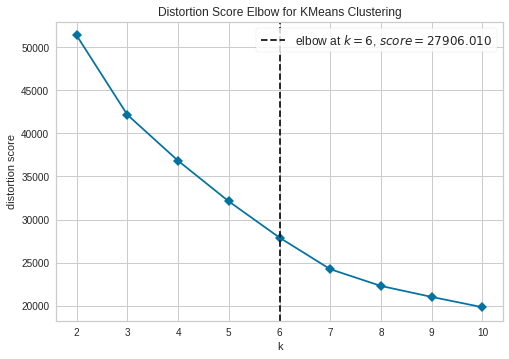

In [ ]:
plot_model(kmeans, plot = 'elbow')

In [ ]:
plot_model(kmeans)

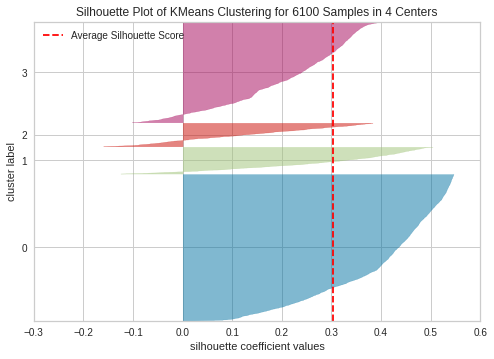

In [ ]:
plot_model(kmeans, plot = 'silhouette')

## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [ ]:
#Kmeans with 6 clusters
kmeans = create_model('kmeans', num_clusters = 6)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2987,2244.6422,1.0957,0,0,0


In [ ]:
plot_model(kmeans)

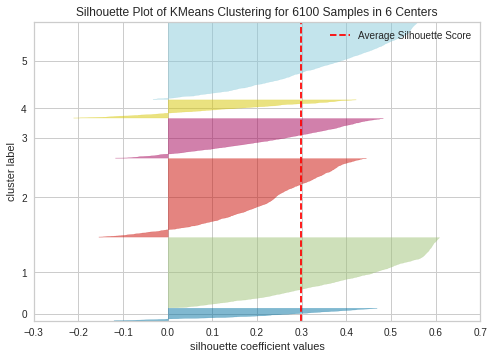

In [ ]:
plot_model(kmeans, plot = 'silhouette')

In [ ]:
kmeans_df = assign_model(kmeans)

In [ ]:
kmeans_df

,CUST_CODE,TotalSpend,TotalVisits,TotalSKUs,FirstDate,LastDate,TicketSize,total_days,recency,TTL_ACTIVE_WEEKS,LIFETIME_WEEKS,PURCHASE_CONSISTENCY,AVG_WKLY_BASKET,SD_WKLY_BASKET,total_spend,total_basket,total_active_week,AVG_TICKET_SIZE,AVG_ACTIVE_WEEKLY_SPEND,MTBP,Cluster
0,CUST0000000181,2.44,1,1,2007-01-06,2007-01-06,2.440000,1,547,1,78.142857,0.012797,1.000000,NaN,2.44,1,1,2.440000,2.440000,NaN,Cluster 1
1,CUST0000000369,959.33,220,189,2006-04-16,2008-07-05,4.360591,812,1,103,116.000000,0.887931,2.135922,1.048328,959.33,220,103,4.360591,9.313883,4.246073,Cluster 0
2,CUST0000000689,328.57,16,116,2007-07-22,2008-06-23,20.535625,338,13,13,50.000000,0.260000,1.230769,0.438529,328.57,16,13,20.535625,25.274615,22.466667,Cluster 5
3,CUST0000000998,5.95,3,4,2006-05-04,2006-07-07,1.983333,65,730,3,113.428571,0.026448,1.000000,0.000000,5.95,3,3,1.983333,1.983333,32.000000,Cluster 1
4,CUST0000001163,39.74,4,24,2006-10-22,2008-06-22,9.935000,610,14,4,89.000000,0.044944,1.000000,0.000000,39.74,4,4,9.935000,9.935000,203.000000,Cluster 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,CUST0000999593,453.58,30,206,2006-05-06,2008-04-02,15.119333,698,95,26,113.142857,0.229798,1.153846,0.464095,453.58,30,26,15.119333,17.445385,24.034483,Cluster 3
6096,CUST0000999645,105.11,11,46,2006-04-30,2008-05-08,9.555455,740,59,10,114.000000,0.087719,1.100000,0.316228,105.11,11,10,9.555455,10.511000,73.900000,Cluster 2
6097,CUST0000999654,5.86,1,4,2006-06-25,2006-06-25,5.860000,1,742,1,106.000000,0.009434,1.000000,NaN,5.86,1,1,5.860000,5.860000,NaN,Cluster 1
6098,CUST0000999935,444.17,21,127,2006-11-29,2008-06-05,21.150952,555,31,19,83.571429,0.227350,1.105263,0.315302,444.17,21,19,21.150952,23.377368,29.157895,Cluster 3


In [ ]:
kmeans_df.groupby('Cluster').describe()

TotalSpend               ...        MTBP            
               count         mean  ...         75%         max
Cluster                            ...                        
Cluster 0      260.0  2806.822846  ...    6.227116   12.634921
Cluster 1     1448.0    11.378688  ...  102.000000  305.000000
Cluster 2     1620.0    59.405056  ...  269.625000  805.000000
Cluster 3      817.0   679.140894  ...   24.518519  215.666667
Cluster 4      375.0   207.697493  ...  137.708333  656.000000
Cluster 5     1580.0    16.204146  ...  104.000000  286.000000

[6 rows x 136 columns]

In [ ]:
summary = kmeans_df.groupby('Cluster').describe()
summary.to_excel('summary.xlsx')

# **Interpret results and plan for actions**

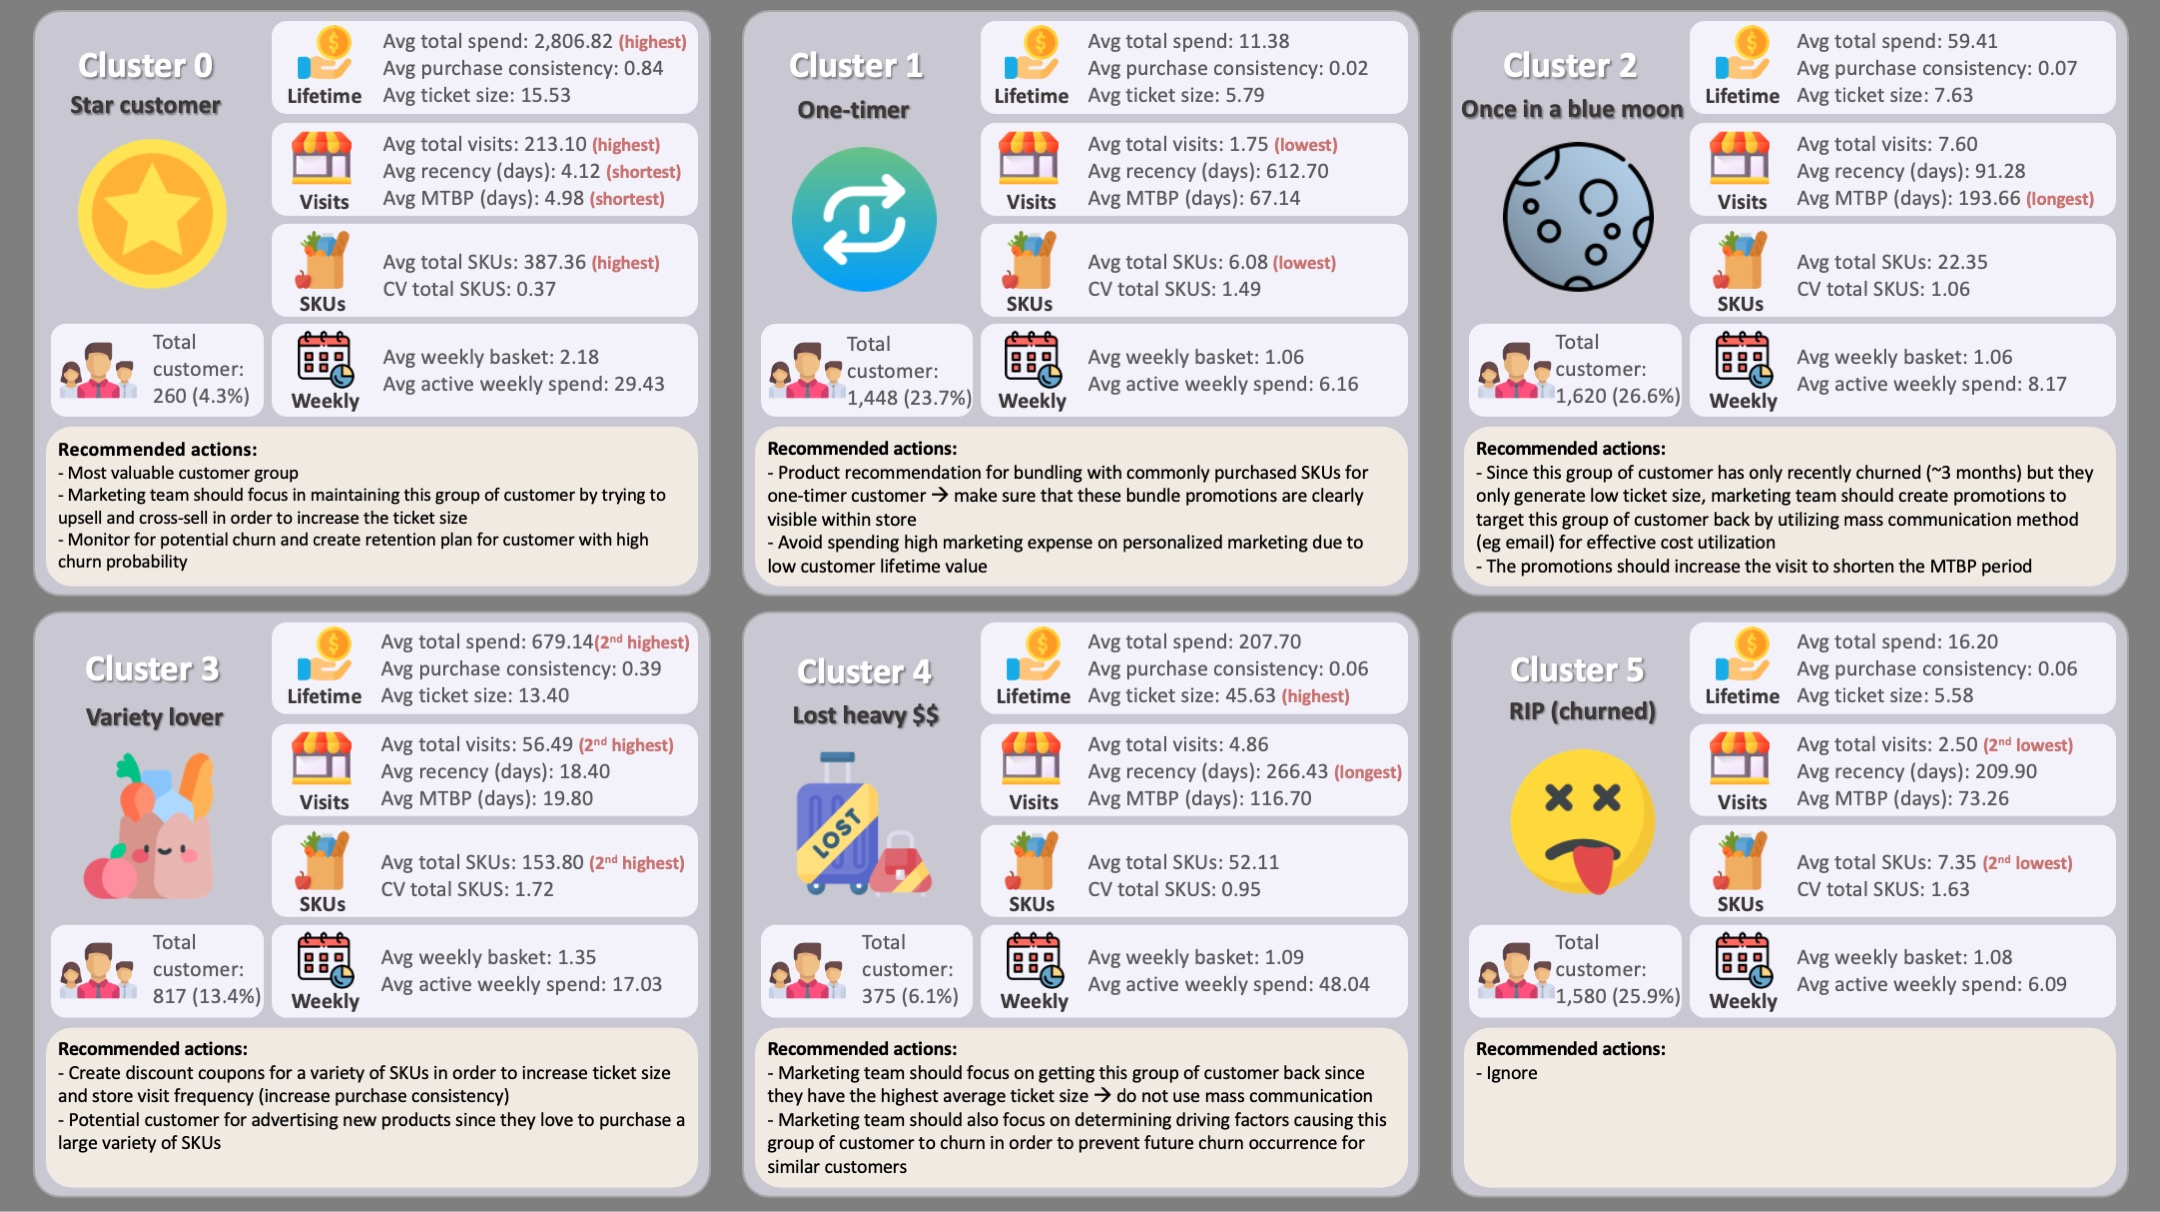

Cluster 0 : The Star
Cluster 1 : Ignore them!!
Cluster 2 : Visit once in a blue moon
Cluster 3 : Potential Star
Cluster 4 : Non frequent visitors
Cluster 5 : Not worth pursuing

